# Setup

In [33]:
import numpy as np
import pandas as pd

import scipy.stats
from statsmodels.tsa.deterministic import DeterministicProcess
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression  
from scipy.signal import periodogram

import lightgbm as lgbm

import seaborn as sns
from matplotlib import pyplot as plt
sns.set_theme()

# Functions and Parameters

In [2]:
# Periodogram Function taken from https://www.kaggle.com/code/ryanholbrook/seasonality

def plot_periodogram(ts, detrend='linear', ax=None):
    fs = pd.Timedelta("1Y") / pd.Timedelta("1D")
    freqencies, spectrum = periodogram(
        ts,
        fs=fs,
        detrend=detrend,
        window="boxcar",
        scaling='spectrum',
    )
    if ax is None:
        _, ax = plt.subplots()
    ax.step(freqencies, spectrum, color="purple")
    ax.set_xscale("log")
    ax.set_xticks([1, 2, 4, 6, 12, 26, 52, 104])
    ax.set_xticklabels(
        [
            "Annual (1)",
            "Semiannual (2)",
            "Quarterly (4)",
            "Bimonthly (6)",
            "Monthly (12)",
            "Biweekly (26)",
            "Weekly (52)",
            "Semiweekly (104)",
        ],
        rotation=30,
    )
    ax.ticklabel_format(axis="y", style="sci", scilimits=(0, 0))
    ax.set_ylabel("Variance")
    ax.set_title("Periodogram")
    return ax

In [3]:
COLS_TO_ENCODE = ["country", "store", "product"]
RANDOM_STATE = 1

# EDA

In [4]:
data_with_predictions = pd.read_csv("train.csv")
submission_df = pd.read_csv("test.csv")

In [5]:
data_with_predictions.head(10)

,id,date,country,store,product,num_sold
0,0,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Improve Your Coding,63
1,1,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Train More LLMs,66
2,2,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win Friends and Influence People,9
3,3,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Win More Kaggle Competitions,59
4,4,2017-01-01,Argentina,Kaggle Learn,Using LLMs to Write Better,49
5,5,2017-01-01,Argentina,Kaggle Store,Using LLMs to Improve Your Coding,88
6,6,2017-01-01,Argentina,Kaggle Store,Using LLMs to Train More LLMs,98
7,7,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win Friends and Influence People,14
8,8,2017-01-01,Argentina,Kaggle Store,Using LLMs to Win More Kaggle Competitions,83
9,9,2017-01-01,Argentina,Kaggle Store,Using LLMs to Write Better,69


In [6]:
data_with_predictions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 136950 entries, 0 to 136949
Data columns (total 6 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        136950 non-null  int64 
 1   date      136950 non-null  object
 2   country   136950 non-null  object
 3   store     136950 non-null  object
 4   product   136950 non-null  object
 5   num_sold  136950 non-null  int64 
dtypes: int64(2), object(4)
memory usage: 6.3+ MB


In [7]:
data_with_predictions["date"].value_counts()

2017-01-01    75
2020-05-11    75
2020-05-09    75
2020-05-08    75
2020-05-07    75
              ..
2018-08-29    75
2018-08-28    75
2018-08-27    75
2018-08-26    75
2021-12-31    75
Name: date, Length: 1826, dtype: int64

In [8]:
data_with_predictions["country"].value_counts()

Argentina    27390
Canada       27390
Estonia      27390
Japan        27390
Spain        27390
Name: country, dtype: int64

In [9]:
data_with_predictions["store"].value_counts()

Kaggle Learn    45650
Kaggle Store    45650
Kagglazon       45650
Name: store, dtype: int64

In [10]:
data_with_predictions["product"].value_counts()

Using LLMs to Improve Your Coding                 27390
Using LLMs to Train More LLMs                     27390
Using LLMs to Win Friends and Influence People    27390
Using LLMs to Win More Kaggle Competitions        27390
Using LLMs to Write Better                        27390
Name: product, dtype: int64

## One-Hot Categorical Encoding

In [11]:
one_hot_encoded_values = pd.get_dummies(data_with_predictions[COLS_TO_ENCODE])
one_hot_encoded_values

,country_Argentina,country_Canada,country_Estonia,country_Japan,country_Spain,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better
0,1,0,0,0,0,0,1,0,1,0,0,0,0
1,1,0,0,0,0,0,1,0,0,1,0,0,0
2,1,0,0,0,0,0,1,0,0,0,1,0,0
3,1,0,0,0,0,0,1,0,0,0,0,1,0
4,1,0,0,0,0,0,1,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
136945,0,0,0,0,1,1,0,0,1,0,0,0,0
136946,0,0,0,0,1,1,0,0,0,1,0,0,0
136947,0,0,0,0,1,1,0,0,0,0,1,0,0
136948,0,0,0,0,1,1,0,0,0,0,0,1,0


In [12]:
data_with_predictions_with_dummies = data_with_predictions.merge(one_hot_encoded_values, how="inner", left_index=True, right_index=True)

cols_to_drop = COLS_TO_ENCODE
cols_to_drop.append("id")

data_with_predictions_with_dummies.drop(columns=cols_to_drop, inplace=True)
data_with_predictions_with_dummies["date"] = pd.to_datetime(data_with_predictions_with_dummies["date"])
data_with_predictions_with_dummies = data_with_predictions_with_dummies.set_index("date")
data_with_predictions_with_dummies["year"] = data_with_predictions_with_dummies.index.year
data_with_predictions_with_dummies["month"] = data_with_predictions_with_dummies.index.month 
data_with_predictions_with_dummies["day"] = data_with_predictions_with_dummies.index.day

In [13]:
data_with_predictions_with_dummies.reset_index(drop=True, inplace=True)
data_with_predictions_with_dummies

,num_sold,country_Argentina,country_Canada,country_Estonia,country_Japan,country_Spain,store_Kagglazon,store_Kaggle Learn,store_Kaggle Store,product_Using LLMs to Improve Your Coding,product_Using LLMs to Train More LLMs,product_Using LLMs to Win Friends and Influence People,product_Using LLMs to Win More Kaggle Competitions,product_Using LLMs to Write Better,year,month,day
0,63,1,0,0,0,0,0,1,0,1,0,0,0,0,2017,1,1
1,66,1,0,0,0,0,0,1,0,0,1,0,0,0,2017,1,1
2,9,1,0,0,0,0,0,1,0,0,0,1,0,0,2017,1,1
3,59,1,0,0,0,0,0,1,0,0,0,0,1,0,2017,1,1
4,49,1,0,0,0,0,0,1,0,0,0,0,0,1,2017,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136945,700,0,0,0,0,1,1,0,0,1,0,0,0,0,2021,12,31
136946,752,0,0,0,0,1,1,0,0,0,1,0,0,0,2021,12,31
136947,111,0,0,0,0,1,1,0,0,0,0,1,0,0,2021,12,31
136948,641,0,0,0,0,1,1,0,0,0,0,0,1,0,2021,12,31


In [14]:
num_sold_per_day = data_with_predictions.groupby(["country", "date"])[["num_sold"]].mean()
num_sold_per_day.reset_index(inplace=True)
num_sold_per_day["date"] = pd.to_datetime(num_sold_per_day["date"])
num_sold_per_day

,country,date,num_sold
0,Argentina,2017-01-01,134.066667
1,Argentina,2017-01-02,99.133333
2,Argentina,2017-01-03,96.533333
3,Argentina,2017-01-04,90.466667
4,Argentina,2017-01-05,87.733333
...,...,...,...
9125,Spain,2021-12-27,211.466667
9126,Spain,2021-12-28,239.600000
9127,Spain,2021-12-29,273.733333
9128,Spain,2021-12-30,262.400000


## Visualisations

### Sales - Overall

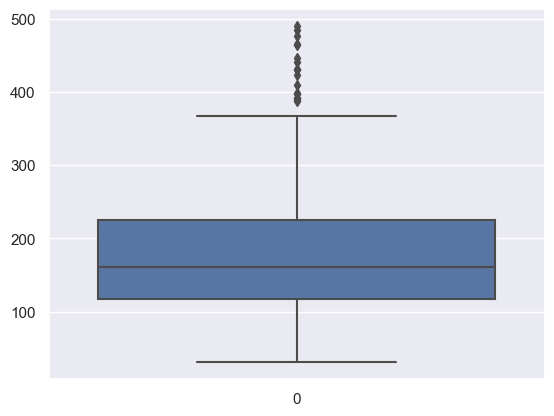

In [15]:
sns.boxplot(num_sold_per_day["num_sold"]);

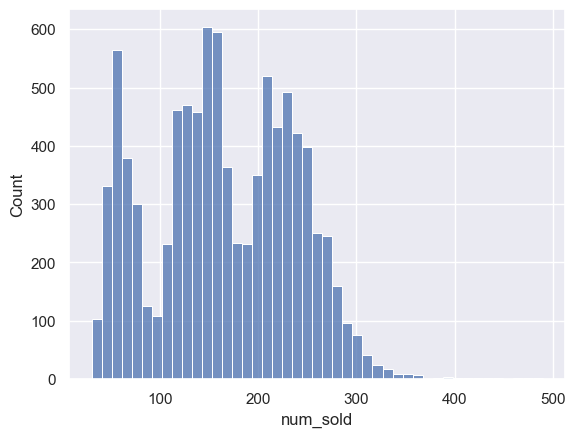

In [16]:
sns.histplot(num_sold_per_day["num_sold"]);

## Sales by Country

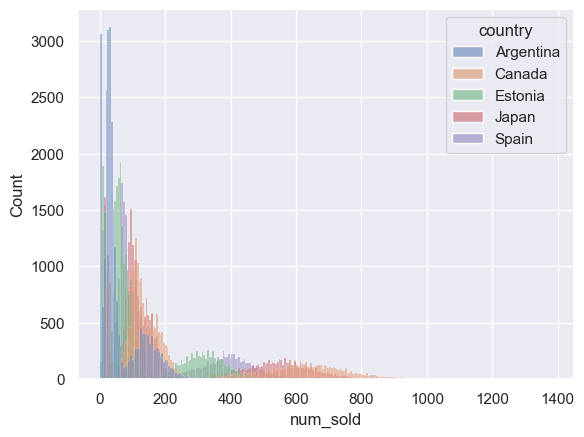

In [17]:
sns.histplot(data_with_predictions, x="num_sold", hue="country");

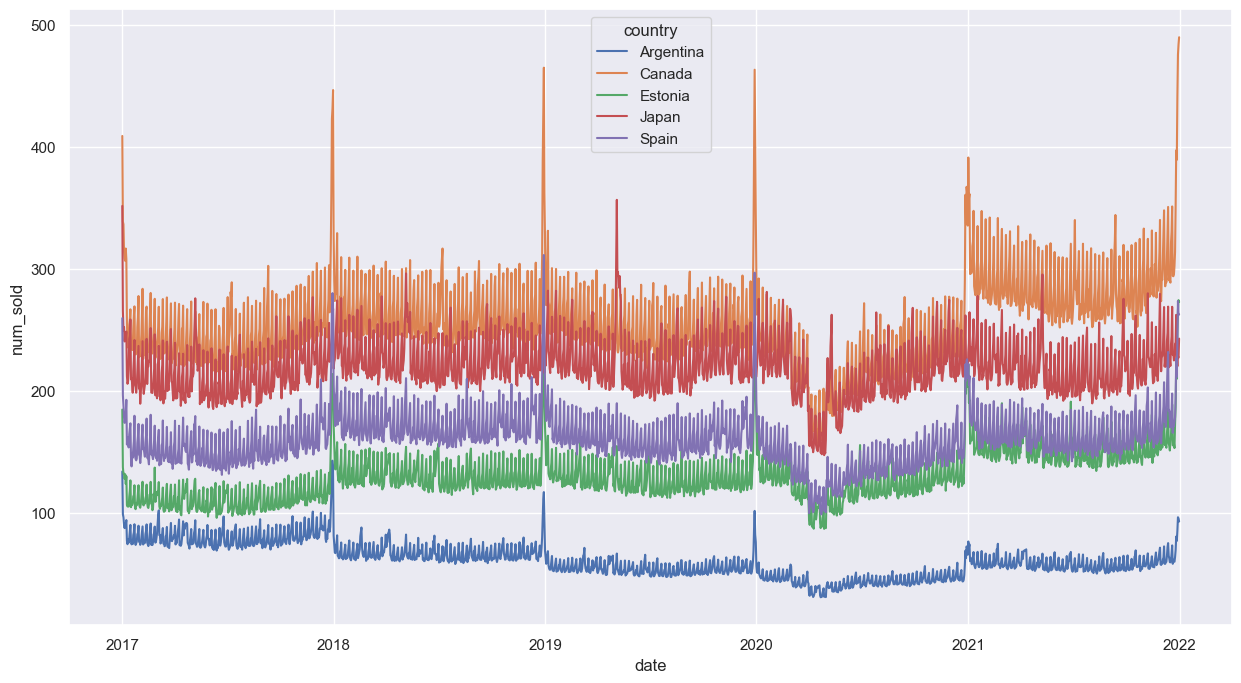

In [18]:
plt.figure(figsize=(15,8))
sns.lineplot(num_sold_per_day, x="date", y="num_sold", hue="country");

## Periodograms

In [19]:
argentina_num_sold_per_day = num_sold_per_day[num_sold_per_day["country"] == "Argentina"][["date", "num_sold"]].set_index("date").squeeze()
canada_num_sold_per_day = num_sold_per_day[num_sold_per_day["country"] == "Canada"][["date", "num_sold"]].set_index("date").squeeze()
estonia_num_sold_per_day = num_sold_per_day[num_sold_per_day["country"] == "Estonia"][["date", "num_sold"]].set_index("date").squeeze()
japan_num_sold_per_day = num_sold_per_day[num_sold_per_day["country"] == "Japan"][["date", "num_sold"]].set_index("date").squeeze()
spain_num_sold_per_day = num_sold_per_day[num_sold_per_day["country"] == "Spain"][["date", "num_sold"]].set_index("date").squeeze()

/var/folders/9d/gkyqvpm50h9dr1t_4gy_88l00000gn/T/ipykernel_86219/3353926855.py:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


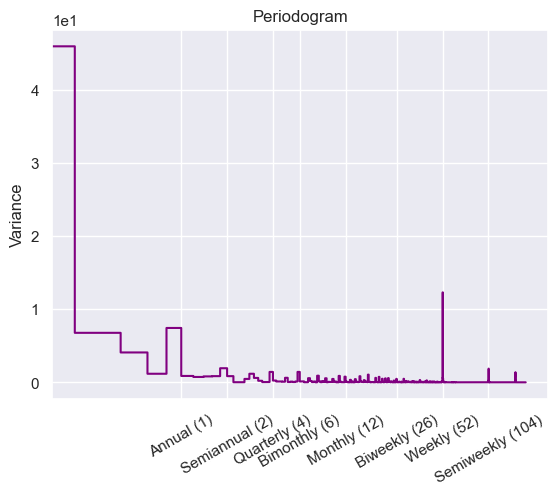

In [20]:
plot_periodogram(argentina_num_sold_per_day);

/var/folders/9d/gkyqvpm50h9dr1t_4gy_88l00000gn/T/ipykernel_86219/3353926855.py:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


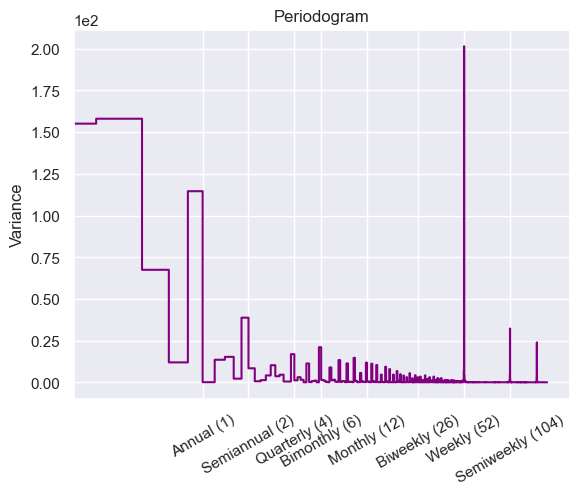

In [21]:
plot_periodogram(canada_num_sold_per_day);

/var/folders/9d/gkyqvpm50h9dr1t_4gy_88l00000gn/T/ipykernel_86219/3353926855.py:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


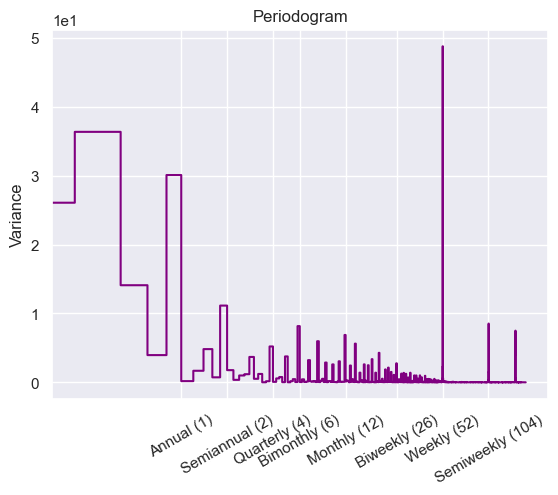

In [22]:
plot_periodogram(estonia_num_sold_per_day);

/var/folders/9d/gkyqvpm50h9dr1t_4gy_88l00000gn/T/ipykernel_86219/3353926855.py:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


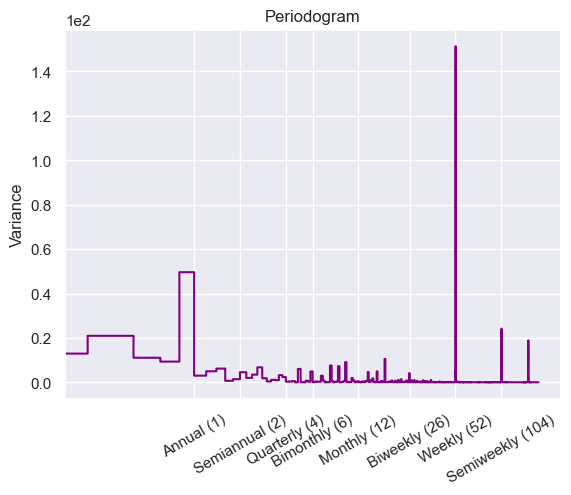

In [23]:
plot_periodogram(japan_num_sold_per_day);

/var/folders/9d/gkyqvpm50h9dr1t_4gy_88l00000gn/T/ipykernel_86219/3353926855.py:4: FutureWarning: Units 'M', 'Y' and 'y' do not represent unambiguous timedelta values and will be removed in a future version.
  fs = pd.Timedelta("1Y") / pd.Timedelta("1D")


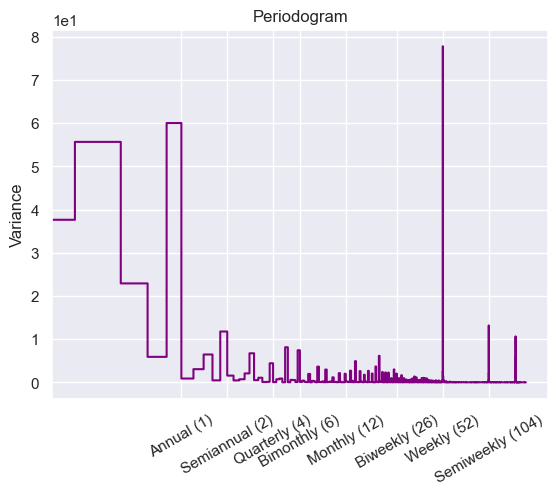

In [24]:
plot_periodogram(spain_num_sold_per_day);

# Thoughts so far
1. Simple Linear Regression won't be enough to make predictions with the whole of this dataset - possibly you could use it for a given country or store.
2. Based on the kaggle hybrid models tutorial (https://www.kaggle.com/code/ryanholbrook/hybrid-models) it looka like using a hybird model to make predictions is the best approach. Depending on how this goes it might be worthwhile thinking about producing models using gradient boosting / random forests and NN.
    - For the latter I have used XGBooost (as that is the most popular/well-known/most tutorials) however, this time I intend to use LightGBM. 
    - For the former I can use TensorFlow.

## Hybrid Models Workflow
1) Train and Predict a Model to learn the components opf the model.
2) Off the back of that model, take the residuals (i.e. the error) and create a model based on these.
3) Combine the result of both the models to make a prediction.

# Models

### Regression & LGBM
Using regression this way I think we will need use a deterministic process on each of the countries seperatley.

### Argentina

In [35]:
argentina_dp = DeterministicProcess( 
    index = argentina_num_sold_per_day.index
    , constant = True
    , order = 2
    , drop = True
)

argentina_dp_trends = argentina_dp.in_sample()

idx_train, idx_test = train_test_split(argentina_num_sold_per_day.index, test_size=0.2, shuffle=False)
idx_train

DatetimeIndex(['2017-01-01', '2017-01-02', '2017-01-03', '2017-01-04',
               '2017-01-05', '2017-01-06', '2017-01-07', '2017-01-08',
               '2017-01-09', '2017-01-10',
               ...
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30'],
              dtype='datetime64[ns]', name='date', length=1460, freq=None)

In [36]:
idx_test

DatetimeIndex(['2020-12-31', '2021-01-01', '2021-01-02', '2021-01-03',
               '2021-01-04', '2021-01-05', '2021-01-06', '2021-01-07',
               '2021-01-08', '2021-01-09',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', name='date', length=366, freq=None)

In [48]:
X_argentina_train, X_argentina_test = argentina_dp_trends.loc[idx_train], argentina_dp_trends.loc[idx_test]
y_argentina_train, y_argentina_test = argentina_num_sold_per_day.loc[idx_train], argentina_num_sold_per_day.loc[idx_test]

In [53]:
arg_linear_reg_model = LinearRegression(fit_intercept=False)
arg_linear_reg_model.fit(X_argentina_train, y_argentina_train)

LinearRegression(fit_intercept=False)